# Text and multimedia mining project
## Research question
What makes a movie review professional?

## Dataset
https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset?select=rotten_tomatoes_critic_reviews.csv

#Imports

In [103]:
# !pip install nltk
# !pip install textblob
# !pip install seaborn
# !pip install wordcloud

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from nltk import FreqDist, ngrams
from nltk.probability import MLEProbDist
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from textblob import TextBlob
from scipy.stats import pearsonr
from wordcloud import WordCloud

# Data retrieval


In [105]:
reviews = pd.read_csv('rotten_tomatoes_critic_reviews.csv')[['top_critic', 'review_score', 'review_content']]
print(reviews)

         top_critic review_score  \
0             False          NaN   
1             False          NaN   
2             False          NaN   
3             False        3.5/5   
4              True          NaN   
...             ...          ...   
1130012       False          2/5   
1130013       False        3.5/5   
1130014       False           B+   
1130015       False        3.5/5   
1130016       False            C   

                                            review_content  
0        A fantasy adventure that fuses Greek mythology...  
1        Uma Thurman as Medusa, the gorgon with a coiff...  
2        With a top-notch cast and dazzling special eff...  
3        Whether audiences will get behind The Lightnin...  
4        What's really lacking in The Lightning Thief i...  
...                                                    ...  
1130012                                                NaN  
1130013  Seen today, it's not only a startling indictme...  
1130014  A rousing

# Data processing
In the dataset there some value are not filled in, those will be removed.

In [106]:
reviews = reviews.dropna()
print(len(reviews))

758709


For the review_score several scoring methods are used. To fix this issue all scores will be conversed to a value between 1 and 5 or if that is not possible the reviews will be removed.

In [107]:
def convert_score(score):
    # check if score is a single number
    # with single numbers the scale is unknown, so those scores are set to None
    if score.isnumeric():
        return None

    # check if score looks like 'a/b'
    elif '/' in score:
        a, b = score.split('/')
        # check if score looks like 'a/0'
        if float(b) in [5.0, 10.0, 100.0]:
            score = round(5 * float(a) / float(b))
            if score == 0 or score > 5:
                return None
            else:
                return score
        else:
            return None

    # score is letter based
    else:
        if 'A' in score:
            return 5
        elif 'B' in score:
            return 4
        elif 'C' in score:
            return 3
        elif 'D' in score:
            return 2
        elif 'F' in score:
            return 1
        else:
            return None

reviews['review_score'] = reviews['review_score'].map(convert_score)
reviews = reviews.dropna()
reviews['review_score'] = reviews['review_score'].astype('int16')
print(len(reviews))

503032


Filter out the reviews that are in another language.

In [108]:
reviews = reviews[~reviews['review_content'].str.lower().str.contains('full review')]
print(len(reviews))

494003


There are some duplicated in the dataset, those will be removed.

In [109]:
reviews = reviews.drop_duplicates()
print(len(reviews))

442005


Add an extra column with the reviews tokenized and the single characters removed

In [110]:
stopwords = set(stopwords.words('english'))
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)
reviews['review_tokens'] = [[token for token in tokenizer.tokenize(review) if len(token) > 1 and not token.lower() == "a" or token.lower() == "i"] for review in reviews.review_content]

The analysis compares the top critics and the non-top critics, so it makes sense to split the dataframe on that column.

In [111]:
top_reviews = reviews[reviews['top_critic'] == True]
print(len(top_reviews))
non_top_reviews = reviews[reviews['top_critic'] == False]
print(len(non_top_reviews))

77693
364312


# N-gram analysis

Functions to extract, count and plot the ngrams.

In [112]:
def extract_ngram_freqs(token_list, n):
    grams = list(ngrams(token_list, n))
    cleaned_grams = []
    for word_tuple in grams:
        for word in word_tuple:
            if word not in stopwords:
                cleaned_grams.append(word_tuple)
                break
    return cleaned_grams

def extract_ngrams(frame, n):
    list_of_grams = []
    for token_list in frame.review_tokens:
        grams = extract_ngram_freqs(token_list, n)
        list_of_grams.append(grams)

    # so grams1, grams2 and so on
    name = 'grams' + str(n)
    if name not in frame.columns:
        frame[name] = list_of_grams
    return frame

def plot_dist_as_cloud(word_dist):
    prob_dist = MLEProbDist(word_dist)
    viz_dict = {}
    for word_tuple in word_dist:
        string = ' '.join(word_tuple)
        viz_dict[string] = prob_dist.prob(word_tuple)

    cloud = WordCloud(width=1600,height=400).generate_from_frequencies(viz_dict)
    plt.figure(figsize = (25,25))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def add_and_print_ngrams(frame, n):
    frame = extract_ngrams(frame, n = n)
    word_dist = FreqDist()
    name = 'grams' + str(n)
    for grams in frame[name]:
        word_dist.update(FreqDist(grams))
    print(f'Found {len(word_dist)} unique n-grams for n = {n}')
    most_common = word_dist.most_common(25)
    for word_tuple in most_common:
        print(word_tuple)
    # calls the helper function for plotting
    plot_dist_as_cloud(word_dist)

Print the ngrams with a equal sample for both the top and the non-top reviews.

Found 1246376 unique n-grams for n = 4
(('one', 'of', 'the', 'most'), 300)
(('is', 'one', 'of', 'the'), 172)
(('one', 'of', 'the', 'best'), 137)
(('turns', 'out', 'to', 'be'), 126)
(('for', 'the', 'most', 'part'), 117)
(('at', 'the', 'same', 'time'), 106)
(('when', 'it', 'comes', 'to'), 105)
(('the', 'rest', 'of', 'the'), 94)
(('is', 'one', 'of', 'those'), 93)
(('is', 'the', 'kind', 'of'), 91)
(('it', 'could', 'have', 'been'), 75)
(('the', 'end', 'of', 'the'), 71)
(('this', 'is', 'one', 'of'), 62)
(('in', 'the', 'way', 'of'), 62)
(('in', 'the', 'first', 'place'), 61)
(("it's", 'hard', 'not', 'to'), 60)
(('it', 'wants', 'to', 'be'), 60)
(('as', 'one', 'of', 'the'), 57)
(('the', 'kind', 'of', 'movie'), 56)
(('in', 'the', 'right', 'place'), 52)
(("it's", 'the', 'kind', 'of'), 51)
(('at', 'the', 'end', 'of'), 50)
(('of', 'the', 'film', 'is'), 50)
(('films', 'of', 'the', 'year'), 50)
(('as', 'well', 'as', 'the'), 49)


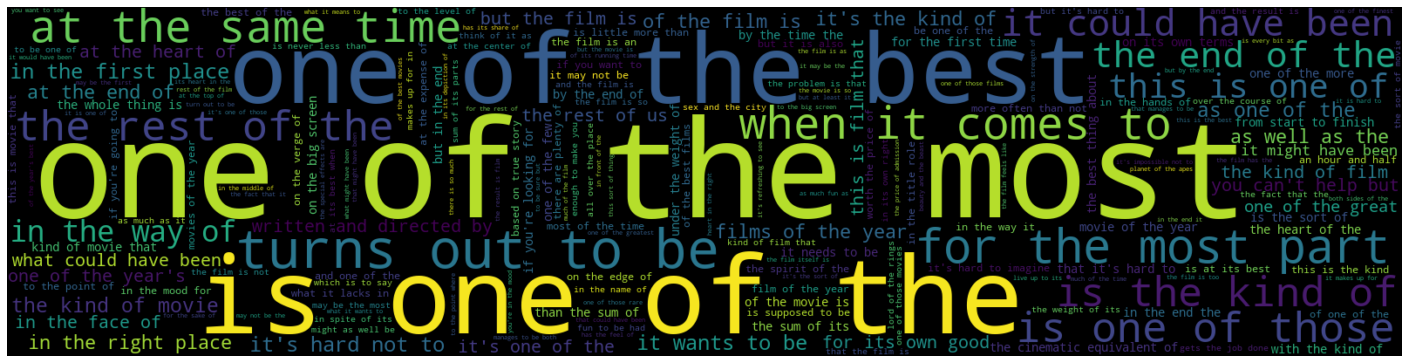

In [113]:
add_and_print_ngrams(top_reviews.sample(n = 75000, random_state=1), 4)

Found 1231753 unique n-grams for n = 4
(('one', 'of', 'the', 'most'), 403)
(('one', 'of', 'the', 'best'), 392)
(('is', 'one', 'of', 'the'), 294)
(('at', 'the', 'same', 'time'), 125)
(('the', 'rest', 'of', 'the'), 122)
(('films', 'of', 'the', 'year'), 120)
(('when', 'it', 'comes', 'to'), 118)
(('this', 'is', 'one', 'of'), 114)
(('of', 'the', 'best', 'films'), 112)
(('for', 'the', 'most', 'part'), 107)
(('on', 'the', 'big', 'screen'), 100)
(('it', 'could', 'have', 'been'), 91)
(('as', 'one', 'of', 'the'), 91)
(('the', 'end', 'of', 'the'), 91)
(('from', 'start', 'to', 'finish'), 91)
(('the', 'best', 'films', 'of'), 87)
(('is', 'the', 'kind', 'of'), 87)
(('is', 'one', 'of', 'those'), 86)
(('of', 'the', 'film', 'is'), 83)
(('one', 'of', 'the', "year's"), 73)
(('in', 'the', 'first', 'place'), 68)
(('it', 'wants', 'to', 'be'), 66)
(('the', 'kind', 'of', 'movie'), 65)
(('turns', 'out', 'to', 'be'), 64)
(('the', 'best', 'of', 'the'), 63)


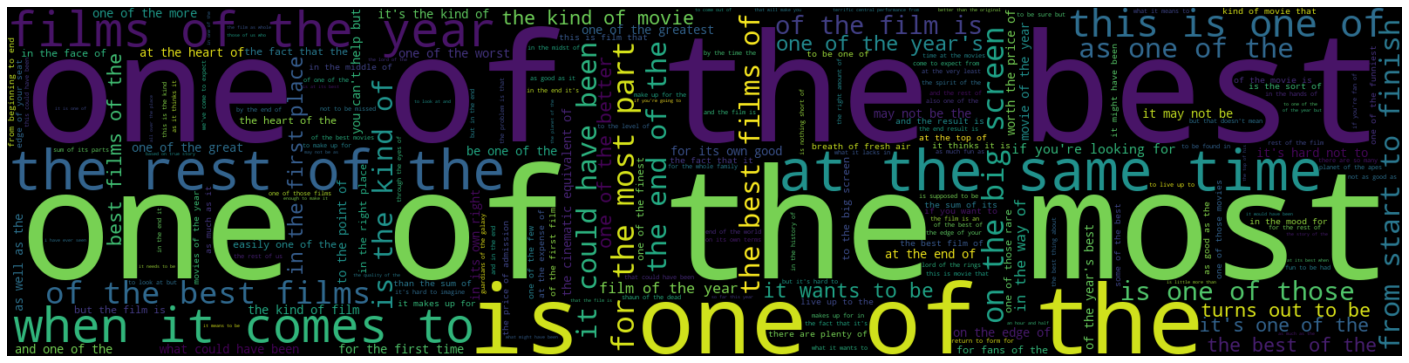

In [114]:
add_and_print_ngrams(non_top_reviews.sample(n = 75000, random_state=1), 4)

Found 1229403 unique n-grams for n = 5
(('is', 'one', 'of', 'the', 'most'), 50)
(('the', 'kind', 'of', 'movie', 'that'), 34)
(('this', 'is', 'one', 'of', 'the'), 30)
(('this', 'is', 'the', 'kind', 'of'), 29)
(('is', 'one', 'of', 'the', 'best'), 29)
(('is', 'the', 'kind', 'of', 'movie'), 28)
(('than', 'the', 'sum', 'of', 'its'), 27)
(('one', 'of', 'the', 'best', 'films'), 26)
(('the', 'kind', 'of', 'film', 'that'), 24)
(('the', 'sum', 'of', 'its', 'parts'), 24)
(('this', 'is', 'one', 'of', 'those'), 23)
(('the', 'rest', 'of', 'the', 'film'), 23)
(('at', 'the', 'end', 'of', 'the'), 23)
(('is', 'at', 'its', 'best', 'when'), 21)
(('worth', 'the', 'price', 'of', 'admission'), 21)
(('under', 'the', 'weight', 'of', 'its'), 20)
(('one', 'of', 'the', "year's", 'best'), 20)
(('one', 'of', 'the', 'best', 'movies'), 20)
(('if', "you're", 'in', 'the', 'mood'), 18)
(('it', 'makes', 'up', 'for', 'in'), 18)
(('much', 'in', 'the', 'way', 'of'), 18)
(('the', 'rest', 'of', 'the', 'movie'), 18)
(('the', '

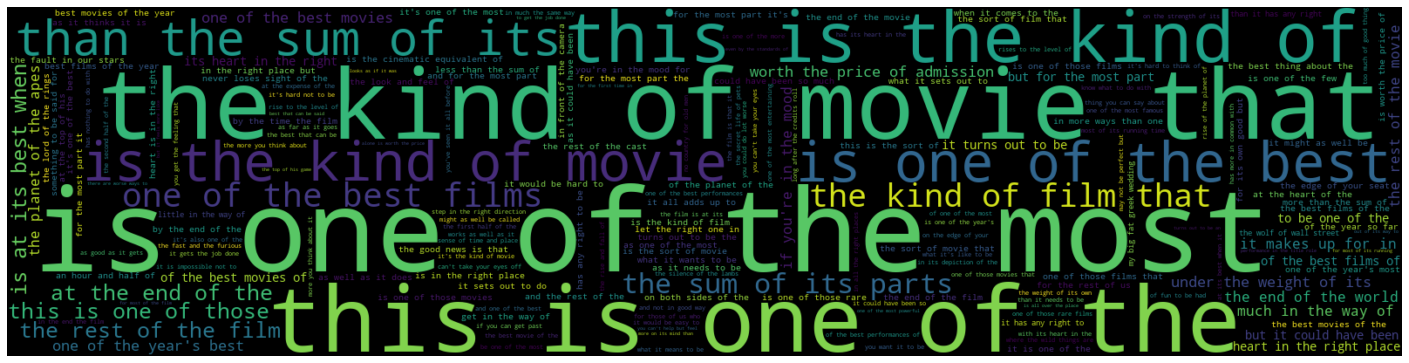

In [115]:
add_and_print_ngrams(top_reviews.sample(n = 75000, random_state=1), 5)

Found 1222513 unique n-grams for n = 5
(('one', 'of', 'the', 'best', 'films'), 111)
(('of', 'the', 'best', 'films', 'of'), 83)
(('is', 'one', 'of', 'the', 'best'), 72)
(('is', 'one', 'of', 'the', 'most'), 69)
(('this', 'is', 'one', 'of', 'the'), 63)
(('the', 'best', 'films', 'of', 'the'), 60)
(('best', 'films', 'of', 'the', 'year'), 58)
(('one', 'of', 'the', "year's", 'best'), 42)
(('worth', 'the', 'price', 'of', 'admission'), 37)
(('at', 'the', 'end', 'of', 'the'), 37)
(('the', 'kind', 'of', 'movie', 'that'), 35)
(('one', 'of', 'the', 'best', 'movies'), 30)
(('this', 'is', 'one', 'of', 'those'), 29)
(('as', 'it', 'thinks', 'it', 'is'), 28)
(('this', 'is', 'the', 'kind', 'of'), 28)
(('and', 'the', 'rest', 'of', 'the'), 28)
(('as', 'one', 'of', 'the', 'best'), 26)
(('than', 'the', 'sum', 'of', 'its'), 26)
(('is', 'the', 'kind', 'of', 'movie'), 26)
(('the', 'edge', 'of', 'your', 'seat'), 26)
(('to', 'be', 'one', 'of', 'the'), 26)
(('the', 'sum', 'of', 'its', 'parts'), 25)
(('the', 'rest'

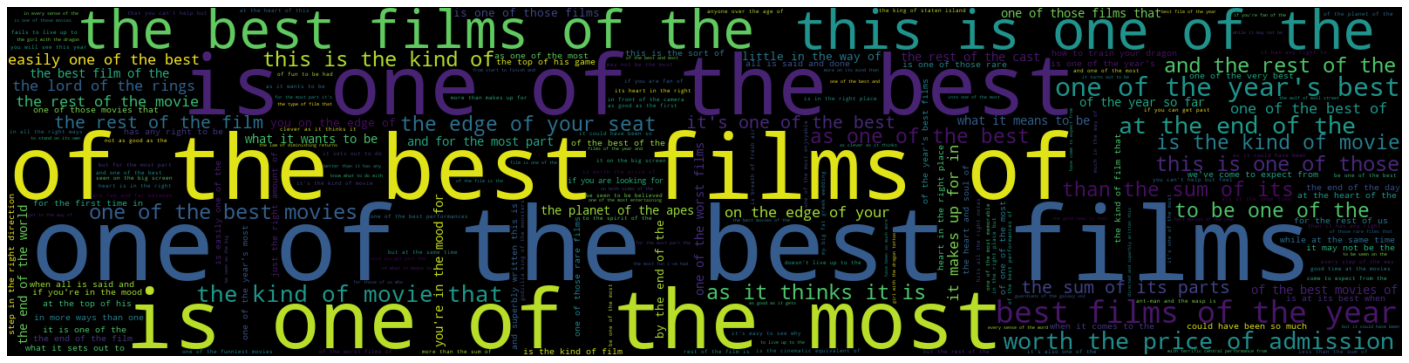

In [116]:
add_and_print_ngrams(non_top_reviews.sample(n = 75000, random_state=1), 5)

Found 1170034 unique n-grams for n = 6
(('than', 'the', 'sum', 'of', 'its', 'parts'), 19)
(('its', 'heart', 'in', 'the', 'right', 'place'), 16)
(('one', 'of', 'the', 'best', 'movies', 'of'), 16)
(('is', 'the', 'kind', 'of', 'movie', 'that'), 16)
(('one', 'of', 'the', 'best', 'films', 'of'), 16)
(('less', 'than', 'the', 'sum', 'of', 'its'), 14)
(('of', 'the', 'best', 'movies', 'of', 'the'), 14)
(('if', "you're", 'in', 'the', 'mood', 'for'), 14)
(('the', 'best', 'movies', 'of', 'the', 'year'), 13)
(('of', 'the', 'planet', 'of', 'the', 'apes'), 13)
(('of', 'the', 'best', 'films', 'of', 'the'), 13)
(('what', 'it', 'sets', 'out', 'to', 'do'), 12)
(('the', 'best', 'films', 'of', 'the', 'year'), 12)
(('heart', 'is', 'in', 'the', 'right', 'place'), 11)
(('more', 'than', 'the', 'sum', 'of', 'its'), 10)
(('this', 'is', 'the', 'kind', 'of', 'movie'), 10)
(('is', 'the', 'kind', 'of', 'film', 'that'), 10)
(('you', "can't", 'take', 'your', 'eyes', 'off'), 9)
(('is', 'at', 'its', 'best', 'when', 'it'

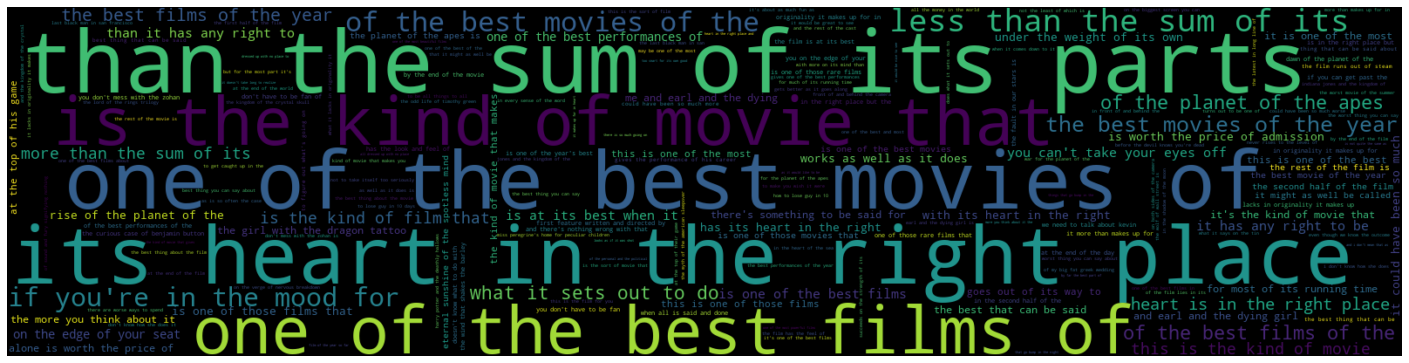

In [117]:
add_and_print_ngrams(top_reviews.sample(n = 75000, random_state=1), 6)

Found 1165922 unique n-grams for n = 6
(('one', 'of', 'the', 'best', 'films', 'of'), 83)
(('of', 'the', 'best', 'films', 'of', 'the'), 57)
(('the', 'best', 'films', 'of', 'the', 'year'), 55)
(('is', 'one', 'of', 'the', 'best', 'films'), 30)
(('on', 'the', 'edge', 'of', 'your', 'seat'), 20)
(('one', 'of', 'the', 'best', 'movies', 'of'), 19)
(('than', 'the', 'sum', 'of', 'its', 'parts'), 19)
(('you', 'on', 'the', 'edge', 'of', 'your'), 18)
(('this', 'is', 'one', 'of', 'the', 'best'), 17)
(('one', 'of', 'the', 'best', 'of', 'the'), 17)
(('at', 'the', 'end', 'of', 'the', 'day'), 17)
(('one', 'of', 'the', "year's", 'best', 'films'), 16)
(('if', "you're", 'in', 'the', 'mood', 'for'), 14)
(('when', 'all', 'is', 'said', 'and', 'done'), 14)
(('is', 'the', 'kind', 'of', 'movie', 'that'), 14)
(('heart', 'is', 'in', 'the', 'right', 'place'), 14)
(('its', 'heart', 'in', 'the', 'right', 'place'), 13)
(('than', 'it', 'has', 'any', 'right', 'to'), 13)
(('at', 'the', 'top', 'of', 'his', 'game'), 12)
((

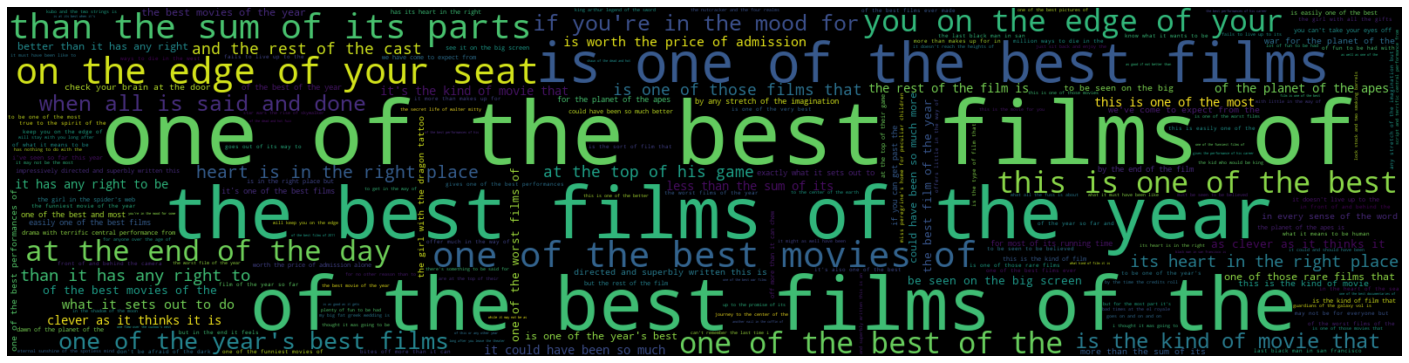

In [118]:
add_and_print_ngrams(non_top_reviews.sample(n = 75000, random_state=1), 6)

Found 1101207 unique n-grams for n = 7
(('one', 'of', 'the', 'best', 'movies', 'of', 'the'), 14)
(('of', 'the', 'best', 'movies', 'of', 'the', 'year'), 13)
(('one', 'of', 'the', 'best', 'films', 'of', 'the'), 13)
(('of', 'the', 'best', 'films', 'of', 'the', 'year'), 12)
(('less', 'than', 'the', 'sum', 'of', 'its', 'parts'), 11)
(('with', 'its', 'heart', 'in', 'the', 'right', 'place'), 8)
(('than', 'it', 'has', 'any', 'right', 'to', 'be'), 8)
(('has', 'its', 'heart', 'in', 'the', 'right', 'place'), 8)
(('rise', 'of', 'the', 'planet', 'of', 'the', 'apes'), 8)
(('more', 'than', 'the', 'sum', 'of', 'its', 'parts'), 7)
(('me', 'and', 'earl', 'and', 'the', 'dying', 'girl'), 7)
(('is', 'one', 'of', 'the', 'best', 'films', 'of'), 6)
(('is', 'one', 'of', 'the', 'best', 'movies', 'of'), 6)
(('of', 'the', 'planet', 'of', 'the', 'apes', 'is'), 6)
(('lacks', 'in', 'originality', 'it', 'makes', 'up', 'for'), 5)
(('in', 'originality', 'it', 'makes', 'up', 'for', 'in'), 5)
(('this', 'is', 'the', 'kind

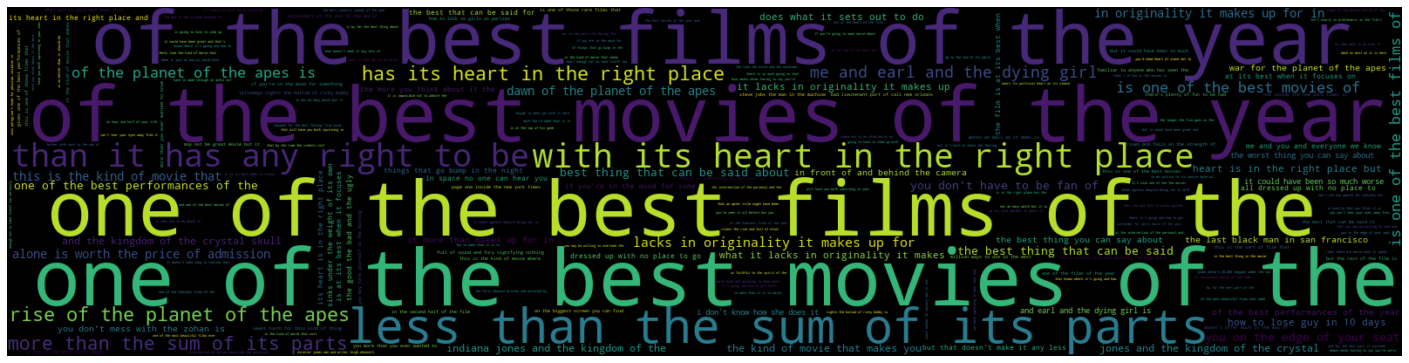

In [119]:
add_and_print_ngrams(top_reviews.sample(n = 75000, random_state=1), 7)

Found 1098187 unique n-grams for n = 7
(('one', 'of', 'the', 'best', 'films', 'of', 'the'), 57)
(('of', 'the', 'best', 'films', 'of', 'the', 'year'), 53)
(('is', 'one', 'of', 'the', 'best', 'films', 'of'), 22)
(('you', 'on', 'the', 'edge', 'of', 'your', 'seat'), 17)
(('than', 'it', 'has', 'any', 'right', 'to', 'be'), 11)
(('this', 'is', 'one', 'of', 'the', 'best', 'films'), 10)
(('as', 'clever', 'as', 'it', 'thinks', 'it', 'is'), 10)
(('one', 'of', 'the', 'best', 'movies', 'of', 'the'), 10)
(('of', 'the', 'best', 'movies', 'of', 'the', 'year'), 10)
(('better', 'than', 'it', 'has', 'any', 'right', 'to'), 10)
(('to', 'be', 'seen', 'on', 'the', 'big', 'screen'), 9)
(('less', 'than', 'the', 'sum', 'of', 'its', 'parts'), 9)
(('war', 'for', 'the', 'planet', 'of', 'the', 'apes'), 8)
(('one', 'of', 'the', 'best', 'of', 'the', 'year'), 8)
(('impressively', 'directed', 'and', 'superbly', 'written', 'this', 'is'), 8)
(('has', 'its', 'heart', 'in', 'the', 'right', 'place'), 7)
(('heart', 'is', 'in

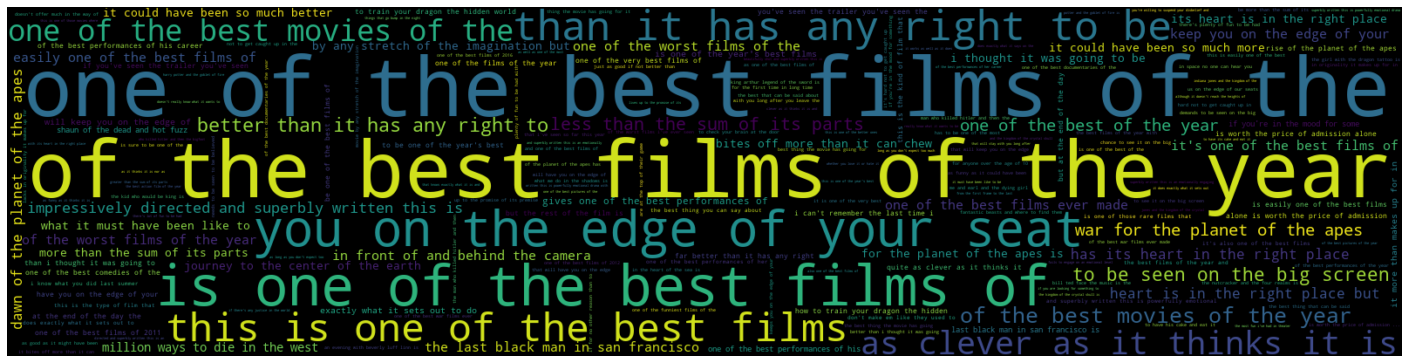

In [120]:
add_and_print_ngrams(non_top_reviews.sample(n = 75000, random_state=1), 7)

# Sentiment analysis

Print the average review scores.

In [124]:
print("Average of", len(top_reviews['review_score']), "top critic scores:", round(sum(top_reviews['review_score']) / len(top_reviews['review_score']), 4))
print("Average of", len(non_top_reviews['review_score']), "non-top critic scores:", round(sum(non_top_reviews['review_score']) / len(non_top_reviews['review_score']), 4))


Average of 77693 top critic scores: 3.1838
Average of 364312 non-top critic scores: 3.3268


Visualize the distribution of review scores to understand the overall rating of the reviews.

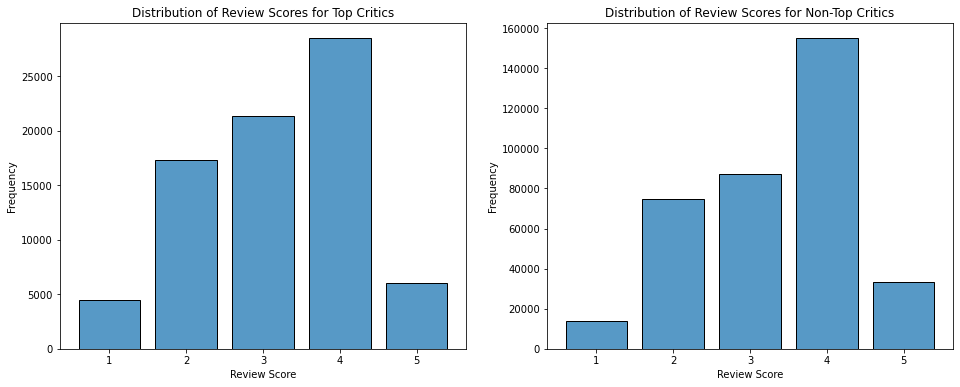

In [122]:
# Distribution of review scores
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for top critics
sns.histplot(top_reviews['review_score'], discrete=True, shrink=0.8, ax=axes[0])
axes[0].set_title('Distribution of Review Scores for Top Critics')
axes[0].set_xlabel('Review Score')
axes[0].set_ylabel('Frequency')

# Plot for non-top critics
sns.histplot(non_top_reviews['review_score'], discrete=True, shrink=0.8, ax=axes[1])
axes[1].set_title('Distribution of Review Scores for Non-Top Critics')
axes[1].set_xlabel('Review Score')
axes[1].set_ylabel('Frequency')

plt.show()

Use sentiment analysis to determine the overall sentiment expressed in the reviews and explore the correlation between review scores and sentiment.

In [126]:
def analyze_sentiment(review):
    blob = TextBlob(review)
    return blob.sentiment.polarity

def analyze_subjectivity(review):
    blob = TextBlob(review)
    return blob.sentiment.subjectivity

# Create copies of the DataFrame to avoid the SettingWithCopyWarning
top_reviews = top_reviews.copy()
non_top_reviews = non_top_reviews.copy()

top_reviews['sentiment_score'] = top_reviews['review_content'].apply(analyze_sentiment)
print("The average sentiment score for top critics:", round(top_reviews['sentiment_score'].mean(), 4))

top_correlation, _ = pearsonr(top_reviews['sentiment_score'], top_reviews['review_score'])
print("Correlation between sentiment and review scores for top critics:", top_correlation.round(4))

top_reviews['subjectivity_score'] = top_reviews['review_content'].apply(analyze_subjectivity)
print("The average subjectivity score for top critics:", round(top_reviews['subjectivity_score'].mean(), 4))

top_correlation, _ = pearsonr(top_reviews['subjectivity_score'], top_reviews['review_score'])
print("Correlation between subjectivity and review scores for top critics:", top_correlation.round(4))

top_correlation, _ = pearsonr(top_reviews['sentiment_score'], top_reviews['subjectivity_score'])
print("Correlation between sentiment and subjectivity scores for top critics:", top_correlation.round(4))


non_top_reviews['sentiment_score'] = non_top_reviews['review_content'].apply(analyze_sentiment)
print("The average sentiment score for non-top critics:", round(non_top_reviews['sentiment_score'].mean(), 4))

non_top_correlation, _ = pearsonr(non_top_reviews['sentiment_score'], non_top_reviews['review_score'])
print("Correlation between sentiment and review scores for non-top critics:", non_top_correlation.round(4))

non_top_reviews['subjectivity_score'] = non_top_reviews['review_content'].apply(analyze_subjectivity)
print("The average subjectivity score for non-top critics:", round(non_top_reviews['subjectivity_score'].mean(), 4))

non_top_correlation, _ = pearsonr(non_top_reviews['subjectivity_score'], non_top_reviews['review_score'])
print("Correlation between subjectivity and review scores for non-top critics:", non_top_correlation.round(4))

non_top_correlation, _ = pearsonr(non_top_reviews['sentiment_score'], non_top_reviews['subjectivity_score'])
print("Correlation between sentiment and subjectivity scores for non-top critics:", non_top_correlation.round(4))


The average sentiment score for top critics: 0.1166
Correlation between sentiment and review scores for top critics: 0.2233
The average subjectivity score for top critics: 0.4997
Correlation between subjectivity and review scores for top critics: 0.0695
Correlation between sentiment and subjectivity scores for top critics: 0.1592
The average sentiment score for non-top critics: 0.138
Correlation between sentiment and review scores for non-top critics: 0.2689
The average subjectivity score for non-top critics: 0.5109
Correlation between subjectivity and review scores for non-top critics: 0.0683
Correlation between sentiment and subjectivity scores for non-top critics: 0.1683
